## Inference of ELLA

In [1]:
from pathlib import Path
from typing import Any, Optional, Union

import fire
import gradio as gr
import safetensors.torch
import torch
from diffusers import DPMSolverMultistepScheduler, StableDiffusionPipeline
from torchvision.utils import save_image

from model import ELLA, T5TextEmbedder

In [2]:
pipe = StableDiffusionPipeline.from_pretrained(
    'runwayml/stable-diffusion-v1-5',
    torch_dtype=torch.float16,
    safety_checker=None,
    feature_extractor=None,
    requires_safety_checker=False,
)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

In [4]:
ella = ELLA()
safetensors.torch.load_model(ella, "sankalp.safetensors", strict=True)
ella.to(pipe.device, dtype=pipe.dtype)
t5_encoder = T5TextEmbedder().to(pipe.device, dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
class ELLAProxyUNet(torch.nn.Module):
    def __init__(self, ella, unet):
        super().__init__()
        # In order to still use the diffusers pipeline, including various workaround

        self.ella = ella
        self.unet = unet
        self.config = unet.config
        self.dtype = unet.dtype
        self.device = unet.device

        self.flexible_max_length_workaround = None

    def forward(
        self,
        sample: torch.FloatTensor,
        timestep: Union[torch.Tensor, float, int],
        encoder_hidden_states: torch.Tensor,
        class_labels: Optional[torch.Tensor] = None,
        timestep_cond: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        cross_attention_kwargs: Optional[dict[str, Any]] = None,
        added_cond_kwargs: Optional[dict[str, torch.Tensor]] = None,
        down_block_additional_residuals: Optional[tuple[torch.Tensor]] = None,
        mid_block_additional_residual: Optional[torch.Tensor] = None,
        down_intrablock_additional_residuals: Optional[tuple[torch.Tensor]] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        return_dict: bool = True,
    ):
        if self.flexible_max_length_workaround is not None:
            time_aware_encoder_hidden_state_list = []
            for i, max_length in enumerate(self.flexible_max_length_workaround):
                time_aware_encoder_hidden_state_list.append(
                    self.ella(encoder_hidden_states[i : i + 1, :max_length], timestep)
                )
            # No matter how many tokens are text features, the ella output must be 64 tokens.
            time_aware_encoder_hidden_states = torch.cat(
                time_aware_encoder_hidden_state_list, dim=0
            )
        else:
            time_aware_encoder_hidden_states = self.ella(
                encoder_hidden_states, timestep
            )

        return self.unet(
            sample=sample,
            timestep=timestep,
            encoder_hidden_states=time_aware_encoder_hidden_states,
            class_labels=class_labels,
            timestep_cond=timestep_cond,
            attention_mask=attention_mask,
            cross_attention_kwargs=cross_attention_kwargs,
            added_cond_kwargs=added_cond_kwargs,
            down_block_additional_residuals=down_block_additional_residuals,
            mid_block_additional_residual=mid_block_additional_residual,
            down_intrablock_additional_residuals=down_intrablock_additional_residuals,
            encoder_attention_mask=encoder_attention_mask,
            return_dict=return_dict,
        )


In [6]:
pipe.unet = ELLAProxyUNet(ella, pipe.unet)

  0%|          | 0/50 [00:00<?, ?it/s]

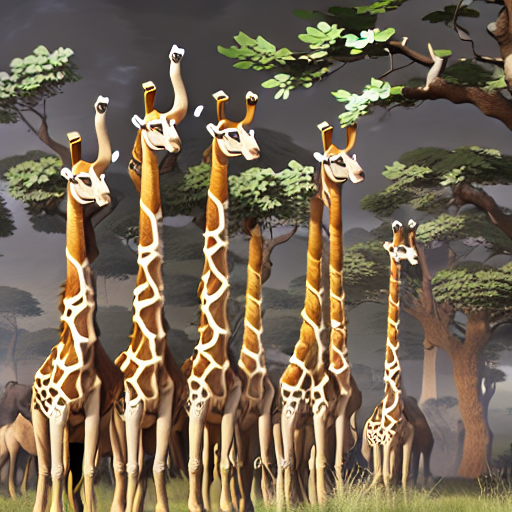

In [27]:
device = pipe.device
dtype = pipe.dtype
prompt = [ "Giraffes with long necks gracefully reach up to nibble on the tender leaves of tall acacia trees in the African savanna. Their golden-brown coats blend with the dry grass, while their distinctive spotted patterns provide camouflage amidst the dappled light filtering through the canopy. The trees sway gently in the breeze, their branches laden with green foliage, as the giraffes rhythmically pluck mouthfuls of leaves with their prehensile tongues. In the distance, a herd of elephants meanders towards a nearby watering hole, completing the iconic tableau of African wildlife."]
batch_size = len(prompt)

prompt_embeds = t5_encoder(prompt, max_length=None).to(device, dtype)
negative_prompt_embeds = t5_encoder(
    [""] * batch_size, max_length=None
).to(device, dtype)

# diffusers pipeline concatenate `prompt_embeds` too early...
# https://github.com/huggingface/diffusers/blob/b6d7e31d10df675d86c6fe7838044712c6dca4e9/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L913
pipe.unet.flexible_max_length_workaround = [
    negative_prompt_embeds.size(1)
] * batch_size + [prompt_embeds.size(1)] * batch_size

max_length = max([prompt_embeds.size(1), negative_prompt_embeds.size(1)])
b, _, d = prompt_embeds.shape
prompt_embeds = torch.cat(
    [
        prompt_embeds,
        torch.zeros(
            (b, max_length - prompt_embeds.size(1), d), device=device, dtype=dtype
        ),
    ],
    dim=1,
)
negative_prompt_embeds = torch.cat(
    [
        negative_prompt_embeds,
        torch.zeros(
            (b, max_length - negative_prompt_embeds.size(1), d),
            device=device,
            dtype=dtype,
        ),
    ],
    dim=1,
)

images = pipe(
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
).images
pipe.unet.flexible_max_length_workaround = None
images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

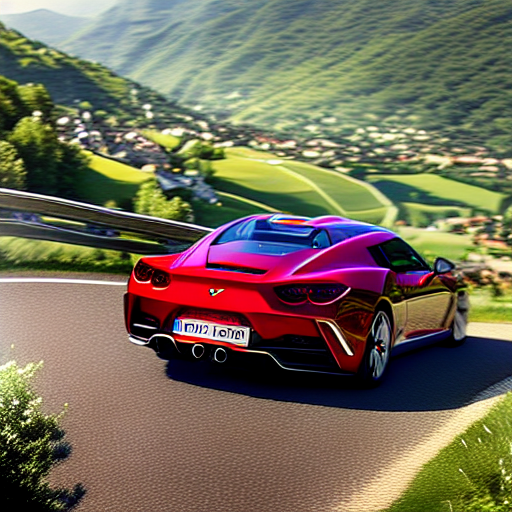

In [25]:
device = pipe.device
dtype = pipe.dtype
prompt = [ "A vibrant red sports car speeds down a winding road nestled amidst lush green hills. The car's sleek, aerodynamic shape cuts through the air as it navigates the curves with precision. The sun glints off its glossy surface, highlighting every contour and reflection. In the distance, a quaint village can be seen, nestled at the foot of the mountains, adding to the picturesque scene."]

batch_size = len(prompt)

prompt_embeds = t5_encoder(prompt, max_length=None).to(device, dtype)
negative_prompt_embeds = t5_encoder(
    [""] * batch_size, max_length=None
).to(device, dtype)

# diffusers pipeline concatenate `prompt_embeds` too early...
# https://github.com/huggingface/diffusers/blob/b6d7e31d10df675d86c6fe7838044712c6dca4e9/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L913
pipe.unet.flexible_max_length_workaround = [
    negative_prompt_embeds.size(1)
] * batch_size + [prompt_embeds.size(1)] * batch_size

max_length = max([prompt_embeds.size(1), negative_prompt_embeds.size(1)])
b, _, d = prompt_embeds.shape
prompt_embeds = torch.cat(
    [
        prompt_embeds,
        torch.zeros(
            (b, max_length - prompt_embeds.size(1), d), device=device, dtype=dtype
        ),
    ],
    dim=1,
)
negative_prompt_embeds = torch.cat(
    [
        negative_prompt_embeds,
        torch.zeros(
            (b, max_length - negative_prompt_embeds.size(1), d),
            device=device,
            dtype=dtype,
        ),
    ],
    dim=1,
)

images = pipe(
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
).images
pipe.unet.flexible_max_length_workaround = None
images[0]